In [1]:
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import pandas as pd 
import numpy as np 


from PIL import Image
#from tensorflow import keras

import tensorflow as tf
from imgaug import augmenters as iaa
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten, Activation, LSTM, TimeDistributed
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate as con
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K

import os
from tensorflow.keras.datasets import fashion_mnist
(trainImages, trainLabels), (testImages, testLabels) = fashion_mnist.load_data()

In [2]:
testImages.shape

(10000, 28, 28)

In [3]:
classNames= ['Tshirt', 'Trouser','Pullover','Dress', 'Coat', 'Sandal', 'Shirt','Sneaker', 'Bag', 'Ankle boot' ]

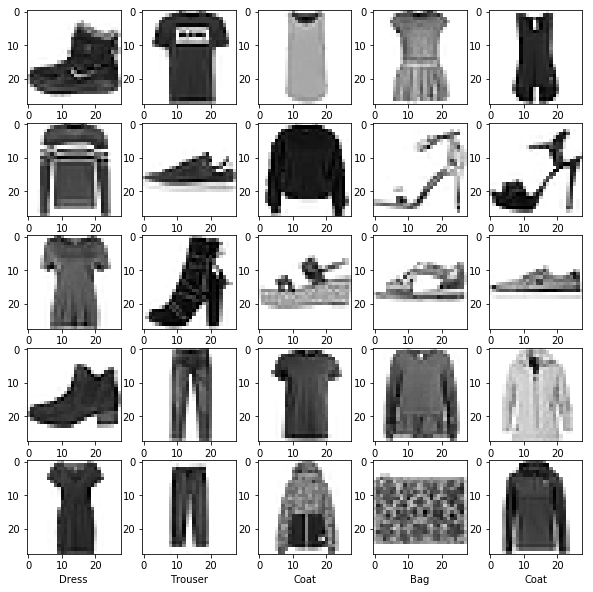

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
  #  plt.xticks([])
  #  plt.yticks([])
    plt.grid(False)
    plt.imshow(trainImages[i] , cmap = plt.cm.binary)
    plt.xlabel(classNames[trainLabels[i]])
plt.show()

In [5]:
trainImages = trainImages.reshape(trainImages.shape[0],28,28,1)
testImages = testImages.reshape(testImages.shape[0],28,28,1)
trainImages = trainImages.astype('float32')
testImages = testImages.astype('float32')
trainImages /= 255
testImages /= 255
print("Training matrix shape", trainImages.shape)
print("Testing matrix shape", testImages.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [6]:
trainLabels = tf.keras.utils.to_categorical(trainLabels, 10)
testLabels = tf.keras.utils.to_categorical(testLabels,10)

In [7]:
trainImages, valImages, trainLabels, valLabels = train_test_split(trainImages,trainLabels, test_size = 0.1, random_state=42)

In [8]:
n_classes = 10

In [9]:
input_shape=(28,28,1)

inputs = Input(name='the_input', shape=input_shape, dtype='float32')  # (None, 224, 224, 3)

    # Convolution layer (VGG)
inner = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(inputs)  # (None, 224, 224, 64)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  # (None,64, 32, 64)

inner = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)  # (None, 112, 112, 128)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)  # (None, 32, 16, 128)

inner = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)  # (None, 56, 56, 256)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)  # (None, 56, 56, 256)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)  # (None, 56, 56, 256)

inner = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(inner)  # (None, 56, 56, 512)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(512, (3, 3), padding='same', name='conv6')(inner)  # (None, 56, 56, 512)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max4')(inner)  # (None, 56, 28, 512)
inner = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(inner)  # (None, 56, 28, 512)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
#inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)  # (None, 32, 64)

inner = Flatten()(inner)
inner = Dense(4096, kernel_initializer='he_normal', name = 'fc1')(inner)
inner = Activation('relu')(inner)
inner = Dropout(0.5)(inner)
inner = Dense(4096, kernel_initializer = 'he_normal',name = 'fc2')(inner)
inner = Activation('relu')(inner)
inner=Dropout(0.5)(inner)
inner = Dense(n_classes, kernel_initializer = 'he_normal',name='dense')(inner)
finalPred = Activation('softmax')(inner)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
cnn = Model(inputs=inputs, outputs= finalPred )

In [11]:
inputs = (28,28,1)


# Base model taken from https://github.com/qjadud1994/CRNN-Keras/blob/master/Model.py#L5
inputz = Input(name='the_input', shape=input_shape, dtype='float32')  # (None, 128, 64, 1)

    # Convolution layer (VGG)
inner = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal' ,activation = 'relu')(inputz)  # (None, 128, 64, 64)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  # (None,64, 32, 64)

inner = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)  # (None, 64, 32, 128)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)  # (None, 32, 16, 128)

inner = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)  # (None, 32, 16, 256)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)  # (None, 32, 16, 256)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)  # (None, 32, 8, 256)

inner = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(inner)  # (None, 32, 8, 512)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(512, (3, 3), padding='same', name='conv6')(inner)  # (None, 32, 8, 512)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max4')(inner)  # (None, 32, 4, 512)
inner = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(inner)  # (None, 32, 4, 512)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)

    # CNN to RNN
inner = tf.keras.layers.Reshape(target_shape=((7, 512)), name='reshape')(inner)  # (None, 32, 2048)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)  # (None, 32, 64)

    # RNN layer
lstm_1 = LSTM(256, return_sequences=False, kernel_initializer='he_normal', name='lstm1')(inner)  # (None, 32, 512)
lstm_1b = LSTM(256, return_sequences=False, go_backwards=True, kernel_initializer='he_normal', name='lstm1_b')(inner)
reversed_lstm_1b = tf.keras.layers.Lambda(lambda inputTensor: K.reverse(inputTensor, axes=1)) (lstm_1b)

lstm1_merged = tf.keras.layers.add([lstm_1, reversed_lstm_1b])  # (None, 32, 512)
lstm1_merged = BatchNormalization()(lstm1_merged)

inner = Dense(n_classes, kernel_initializer = 'he_normal',name='dense')(lstm1_merged)
finalPred1 = Activation('softmax')(inner)

In [12]:
cnn_lstm = Model(inputs=inputz, outputs= finalPred1 )

In [13]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 64)        0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 128)       73856     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 14, 14, 128)       512       
__________

In [14]:
cnn_lstm.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 28, 28, 64)   640         the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 28, 28, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 28, 28, 64)   0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
max1 (MaxP

In [15]:
def f1(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [16]:
cnn.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrics=[ 'accuracy' ,f1])
cnn_lstm.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrics=['accuracy' ,f1])


In [17]:
datagen = IDG( rotation_range=15, 
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False,  
        vertical_flip=False)

filepath = "weights-CNN-FMNIST-{epoch:02d}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

callback =  ReduceLROnPlateau(monitor='val_acc',  patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
datagen.fit(trainImages)


In [36]:
cnn.reset_states()

In [37]:


history = cnn.fit_generator(datagen.flow(trainImages,trainLabels, batch_size=32),
                              epochs = 15, validation_data = (valImages, valLabels),
                              verbose = 1, steps_per_epoch=trainImages.shape[0] // 32, 
                            callbacks = [checkpoint, callback])

Epoch 1/15
6000/6000 [==============================] - 15s 2ms/sample - loss: 0.4716 - acc: 0.8278 - f1: 0.7165

Epoch 00001: val_acc improved from -inf to 0.82783, saving model to weights-CNN-FMNIST-01.hdf5
1688/1688 [==============================] - 824s 488ms/step - loss: 0.7739 - acc: 0.7263 - f1: 0.6217 - val_loss: 0.4711 - val_acc: 0.8278 - val_f1: 0.7165
Epoch 2/15
6000/6000 [==============================] - 18s 3ms/sample - loss: 0.4685 - acc: 0.8275 - f1: 0.7241

Epoch 00002: val_acc did not improve from 0.82783
1688/1688 [==============================] - 870s 515ms/step - loss: 0.5199 - acc: 0.8025 - f1: 0.6998 - val_loss: 0.4676 - val_acc: 0.8275 - val_f1: 0.7241
Epoch 3/15
6000/6000 [==============================] - 15s 3ms/sample - loss: 0.3491 - acc: 0.8638 - f1: 0.7623

Epoch 00003: val_acc improved from 0.82783 to 0.86383, saving model to weights-CNN-FMNIST-03.hdf5
1688/1688 [==============================] - 939s 556ms/step - loss: 0.4482 - acc: 0.8323 - f1: 0.731

NameError: name 'history' is not defined

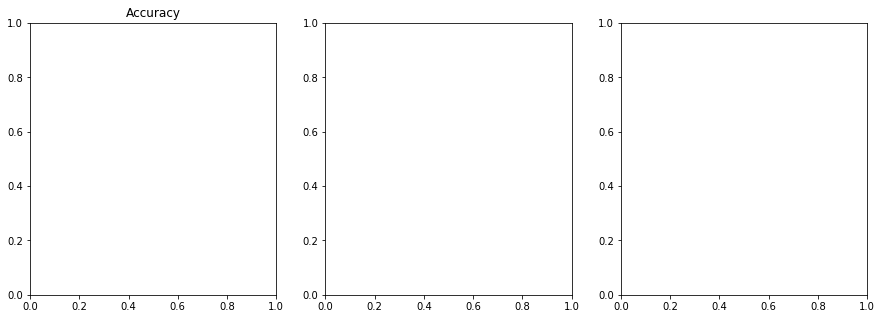

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].set_title('Accuracy')
#ax[0].xlabel('Epoch')
#ax[0].ylabel('Accuracy')
ax[0].plot(history.history['acc'], mark_every= history.history['acc'], label = "Training ")
ax[0].plot(history.history['val_acc'], label = "Valid ")
ax[0].set(xlabel="Epoch", ylabel="Accuracy score")

ax[1].set_title('Loss')
#ax[1].ylabel('Loss')
#ax[1].xlabel('Epoch')
ax[1].plot(history.history['loss'], mark_every = history.history['loss'], label= 'Train ')
ax[1].plot(history.history['val_loss'], label = 'Valid ')
ax[1].set(xlabel="Epoch", ylabel="Loss")

ax[2].set_title('F1')
#ax[2].ylabel('F1 Score')
#ax[2].xlabel('Epoch')
ax[2].set(xlabel="Epoch", ylabel="F1 score")
ax[2].plot(history.history['f1'], label = "Train")
ax[2].plot(history.history['val_f1'], label = "Validation")
ax[2].legend(['train', 'validation'])

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.savefig('CNN_FMNIST.png')

In [20]:
cnn_lstm.reset_states()

In [21]:
filepath = "weights-CNNLSTM-FMNIST-{epoch:02d}.hdf5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

hist = cnn_lstm.fit_generator(datagen.flow(trainImages,trainLabels, batch_size=32),
                              epochs = 15, validation_data = (valImages, valLabels),
                              verbose = 1, steps_per_epoch=trainImages.shape[0] // 32, 
                            callbacks = [checkpoint1, callback])

Epoch 1/15
6000/6000 [==============================] - 17s 3ms/sample - loss: 0.4431 - acc: 0.8308 - f1: 0.7329

Epoch 00001: val_acc improved from -inf to 0.83083, saving model to weights-CNNLSTM-FMNIST-01.hdf5
1688/1688 [==============================] - 1112s 659ms/step - loss: 0.5614 - acc: 0.7904 - f1: 0.6792 - val_loss: 0.4424 - val_acc: 0.8308 - val_f1: 0.7329
Epoch 2/15
6000/6000 [==============================] - 15s 3ms/sample - loss: 0.3275 - acc: 0.8750 - f1: 0.7769

Epoch 00002: val_acc improved from 0.83083 to 0.87500, saving model to weights-CNNLSTM-FMNIST-02.hdf5
1688/1688 [==============================] - 871s 516ms/step - loss: 0.4197 - acc: 0.8444 - f1: 0.7443 - val_loss: 0.3270 - val_acc: 0.8750 - val_f1: 0.7769
Epoch 3/15
6000/6000 [==============================] - 17s 3ms/sample - loss: 0.3622 - acc: 0.8593 - f1: 0.7654

Epoch 00003: val_acc did not improve from 0.87500
1688/1688 [==============================] - 864s 512ms/step - loss: 0.3754 - acc: 0.8600 - 

In [25]:
hist.history['loss']

[0.5613749642990253,
 0.4196103716161516,
 0.37540816943292266,
 0.34337669160189455,
 0.3280417229908484,
 0.31131893359731744,
 0.30148772259111756,
 0.288541265628956,
 0.28108303809386714,
 0.27709209241911215,
 0.2672398317908799,
 0.247305074689013,
 0.23680289574243404,
 0.23401209381885,
 0.23155063057718453]

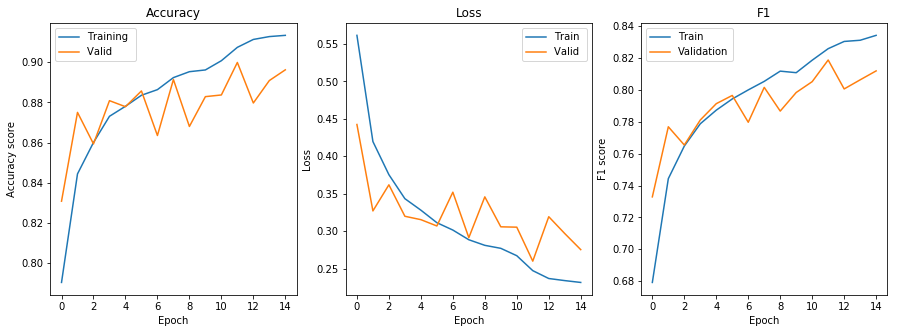

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].set_title('Accuracy')
#ax[0].xlabel('Epoch')
#ax[0].ylabel('Accuracy')
ax[0].plot(hist.history['acc'], label = "Training ")
ax[0].plot(hist.history['val_acc'], label = "Valid ")
ax[0].set(xlabel="Epoch", ylabel="Accuracy score")

ax[1].set_title('Loss')
#ax[1].ylabel('Loss')
#ax[1].xlabel('Epoch')
ax[1].plot(hist.history['loss'],markevery = hist.history['loss'] ,label= 'Train ')
ax[1].plot(hist.history['val_loss'], label = 'Valid ')
ax[1].set(xlabel="Epoch", ylabel="Loss")

ax[2].set_title('F1')
#ax[2].ylabel('F1 Score')
#ax[2].xlabel('Epoch')
ax[2].set(xlabel="Epoch", ylabel="F1 score")
ax[2].plot(hist.history['f1'], label = "Train")
ax[2].plot(hist.history['val_f1'], label = "Validation")
ax[2].legend(['train', 'validation'])

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.savefig('CNNLSTM_FMNIST.png')

In [26]:
cnn.load_weights('weights-CNN-FMNIST-14.hdf5')

In [45]:
cnnLSTM_prediction = cnn_lstm.predict(testImages)
cnn_prediction = cnn.predict(testImages)

In [46]:
cnn_preds = np.argmax(cnn_prediction,axis=1)
cnnLSTM_preds = np.argmax(cnnLSTM_prediction,axis=1)

In [47]:
correct_cnn = np.nonzero(cnn_preds == np.argmax(testLabels,axis=1))[0]
incorrect_cnn = np.nonzero(cnn_preds != np.argmax(testLabels,axis=1))[0]

print("Total Correct for CNN: " + str(len(correct_cnn)))
print("Total Incorrect for CNN: " +str(len(incorrect_cnn)))




correct_cnnLSTM = np.nonzero(cnnLSTM_preds == np.argmax(testLabels,axis=1))[0]
incorrect_cnnLSTM = np.nonzero(cnnLSTM_preds != np.argmax(testLabels,axis=1))[0]

print("Total Correct for CNN-LSTM: " + str(len(correct_cnnLSTM)))
print("Total Incorrect for CNN-LSTM: " +str(len(incorrect_cnnLSTM)))

Total Correct for CNN: 9013
Total Incorrect for CNN: 987
Total Correct for CNN-LSTM: 8946
Total Incorrect for CNN-LSTM: 1054


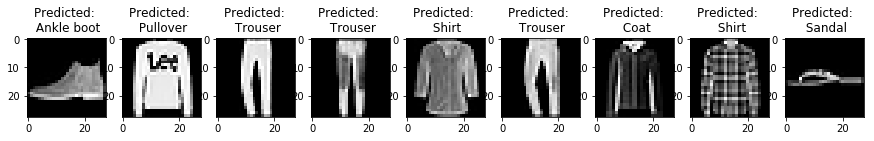

<Figure size 432x288 with 0 Axes>

In [48]:
fig , axs = plt.subplots(1,9, figsize = (15,5))

for x, right in enumerate(correct_cnn[:9]):
    axs[x].imshow(testImages[right].reshape(28,28), cmap='gray', interpolation='none')
    axs[x].set_title("Predicted: \n {}".format(classNames[cnn_preds[right]], np.argmax(testLabels,axis=1)[right]))
#plt.set_size_inches((20,10))
plt.figure()
plt.savefig("Correct_CNN_FMNIST.png")

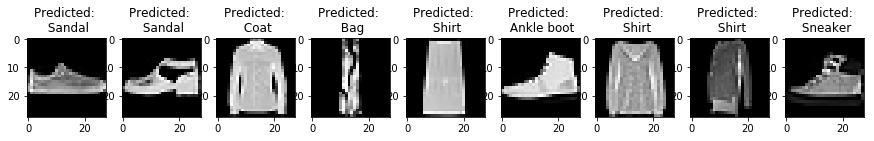

<Figure size 432x288 with 0 Axes>

In [49]:
fig , axs = plt.subplots(1,9, figsize = (15,5))

for x, right in enumerate(incorrect_cnn[:9]):
    axs[x].imshow(testImages[right].reshape(28,28), cmap='gray', interpolation='none')
    axs[x].set_title("Predicted: \n {}".format(classNames[cnn_preds[right]], np.argmax(testLabels,axis=1)[right]))
#plt.set_size_inches((20,10))
plt.figure()
plt.savefig("INCorrect_CNN_FMNIST.png")

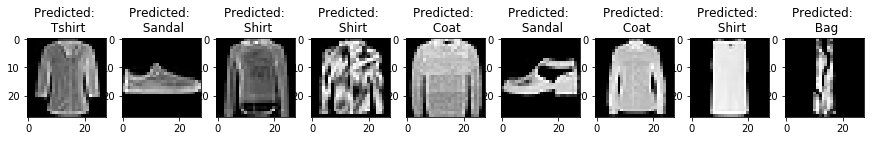

<Figure size 432x288 with 0 Axes>

In [50]:
fig , axs = plt.subplots(1,9, figsize = (15,5))

for x, right in enumerate(incorrect_cnnLSTM[:9]):
    axs[x].imshow(testImages[right].reshape(28,28), cmap='gray', interpolation='none')
    axs[x].set_title("Predicted: \n {}".format(classNames[cnnLSTM_preds[right]], np.argmax(testLabels,axis=1)[right]))
#plt.set_size_inches((20,10))
plt.figure()
plt.savefig("INCorrect_CNNLSTM_FMNIST.png")

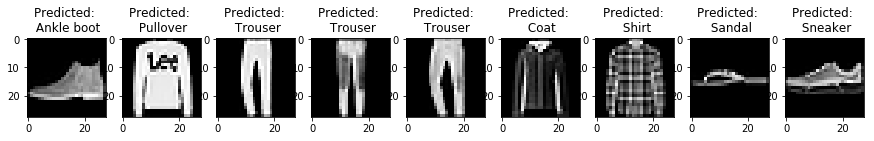

<Figure size 432x288 with 0 Axes>

In [51]:
fig , axs = plt.subplots(1,9, figsize = (15,5))

for x, right in enumerate(correct_cnnLSTM[:9]):
    axs[x].imshow(testImages[right].reshape(28,28), cmap='gray', interpolation='none')
    axs[x].set_title("Predicted: \n {}".format(classNames[cnnLSTM_preds[right]], np.argmax(testLabels,axis=1)[right]))
#plt.set_size_inches((20,10))
plt.figure()
plt.savefig("Correct_CNNLSTM_FMNIST.png")